In [1]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Enable inline plotting and set a clean style
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Helper function to add Source Watermarks
def add_source(ax, text):
    ax.text(0.99, 0.01, text, transform=ax.transAxes,
            fontsize=9, color='gray', alpha=0.7,
            ha='right', va='bottom')

print("Environment Ready. Loading Data Modules...")

Environment Ready. Loading Data Modules...


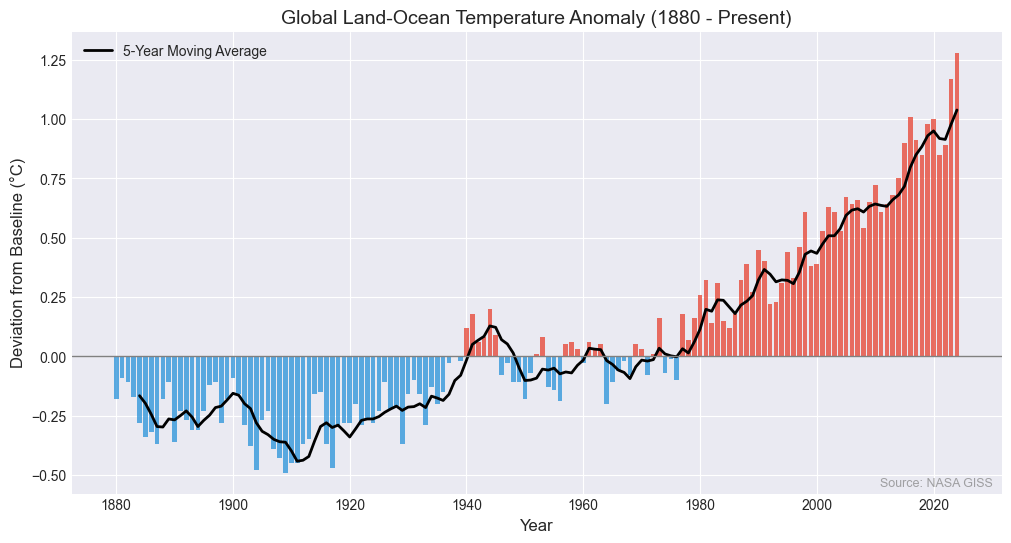

Latest Anomaly (2024): 1.28°C


In [2]:
# Global Temperature Analysis

# 1. Fetch Data directly from NASA GISS
# 'GLB.Ts+dSST.csv' is the Land-Ocean Temperature Index
url_temp = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
print(f"Downloading Temperature Data from: {url_temp}...")

# 2. Process Data
# The first row is headers, but the real data starts slightly later. 
# We skip the first row usually to get clean headers.
df_temp = pd.read_csv(url_temp, skiprows=1)

# Clean up: We only want 'Year' and 'J-D' (Annual Mean)
df_temp = df_temp[['Year', 'J-D']]

# Convert to numeric (sometimes NASA marks missing data with ***)
df_temp['J-D'] = pd.to_numeric(df_temp['J-D'], errors='coerce')
df_temp.dropna(inplace=True)

# 3. Visualization
plt.figure(figsize=(12, 6))

# Color logic: Blue for cool years, Red for warm years
colors = ['#3498db' if x < 0 else '#e74c3c' for x in df_temp['J-D']]

plt.bar(df_temp['Year'], df_temp['J-D'], color=colors, width=0.8, alpha=0.8)

# Add a trend line (Rolling 5-year average)
rolling_avg = df_temp['J-D'].rolling(window=5).mean()
plt.plot(df_temp['Year'], rolling_avg, color='black', linewidth=2, label='5-Year Moving Average')

plt.title('Global Land-Ocean Temperature Anomaly (1880 - Present)', fontsize=14)
plt.ylabel('Deviation from Baseline (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.axhline(0, color='gray', linewidth=1)
plt.legend()
add_source(plt.gca(), "Source: NASA GISS")

plt.show()
print(f"Latest Anomaly ({int(df_temp.iloc[-1]['Year'])}): {df_temp.iloc[-1]['J-D']}°C")

/var/folders/m5/kfy0f66511b6jw_64vvq9trm0000gp/T/ipykernel_82535/930119543.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_co2 = pd.read_csv(url_co2, delim_whitespace=True, comment='#',
/Users/neil.burnettarria.com/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


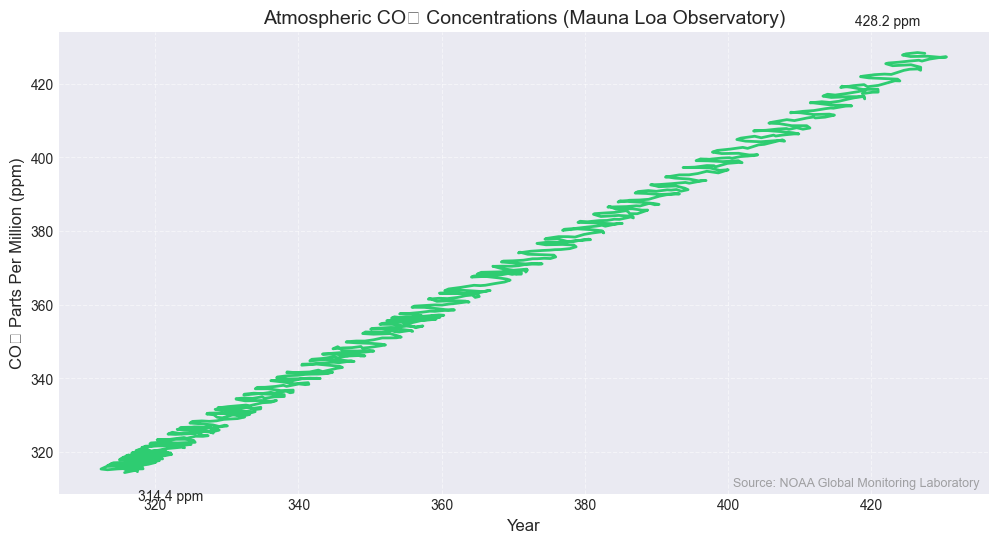

In [3]:
# CO2 Concentration Analysis

# 1. Fetch Data from NOAA
url_co2 = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"
print(f"Downloading CO2 Data from: {url_co2}...")

# 2. Process Data
# Read whitespace-separated file, skip comment lines starting with '#'
df_co2 = pd.read_csv(url_co2, delim_whitespace=True, comment='#', 
                     names=['year', 'month', 'decimal', 'average', 'interpolated', 'trend', 'days'])

# Filter out bad data (sentinel value -99.99)
df_co2 = df_co2[df_co2['average'] > 0]

# 3. Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_co2['decimal'], df_co2['average'], color='#2ecc71', linewidth=2)

plt.title('Atmospheric CO₂ Concentrations (Mauna Loa Observatory)', fontsize=14)
plt.ylabel('CO₂ Parts Per Million (ppm)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate the start and end
start_val = df_co2.iloc[0]['average']
end_val = df_co2.iloc[-1]['average']
plt.annotate(f"{start_val:.1f} ppm", (df_co2.iloc[0]['decimal'], start_val), xytext=(10, -20), textcoords='offset points')
plt.annotate(f"{end_val:.1f} ppm", (df_co2.iloc[-1]['decimal'], end_val), xytext=(-50, 20), textcoords='offset points')

add_source(plt.gca(), "Source: NOAA Global Monitoring Laboratory")
plt.show()

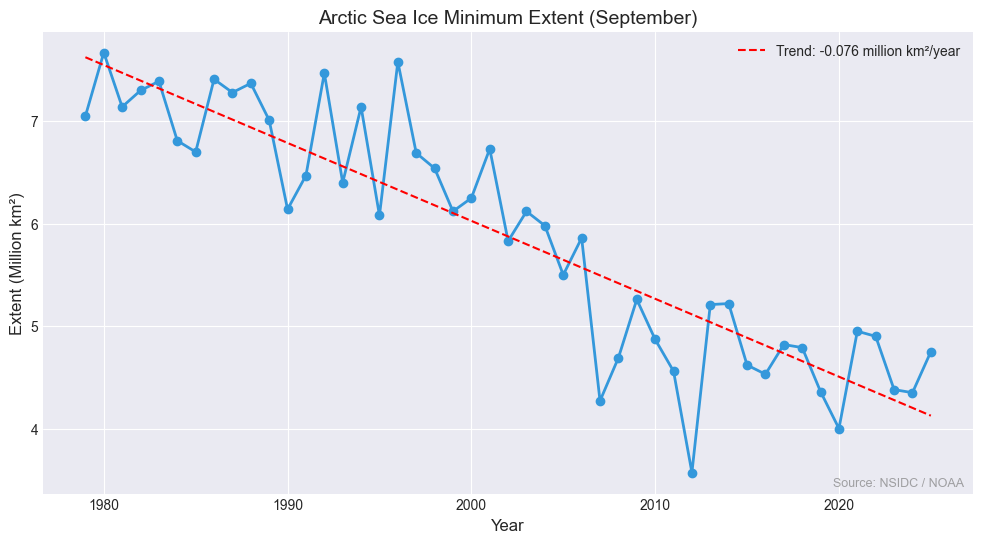

In [7]:
# Arctic Sea Ice Extent (September Minimum)

# 1. Fetch Data from NSIDC (Updated to Version 4.0)
# Note: "N_09" refers to Northern Hemisphere, Month 09 (September)
url_ice = "https://noaadata.apps.nsidc.org/NOAA/G02135/north/monthly/data/N_09_extent_v4.0.csv"
print(f"Downloading Sea Ice Data from: {url_ice}...")

# 2. Process Data
# We use storage_options to mimic a real browser user-agent, 
# preventing occasional 403/404 errors from government servers.
storage_options = {'User-Agent': 'Mozilla/5.0'}
df_ice = pd.read_csv(url_ice, storage_options=storage_options)

# The file contains 'extent' in million square km.
# We strip whitespace from column names just in case
df_ice.columns = df_ice.columns.str.strip()

# 3. Visualization
plt.figure(figsize=(12, 6))

plt.plot(df_ice['year'], df_ice['extent'], marker='o', color='#3498db', linewidth=2, linestyle='-')

# Add a simple linear trend line (Polyfit)
z = np.polyfit(df_ice['year'], df_ice['extent'], 1)
p = np.poly1d(z)
plt.plot(df_ice['year'], p(df_ice['year']), "r--", linewidth=1.5, label=f"Trend: {z[0]:.3f} million km²/year")

plt.title('Arctic Sea Ice Minimum Extent (September)', fontsize=14)
plt.ylabel('Extent (Million km²)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend()
add_source(plt.gca(), "Source: NSIDC / NOAA")

plt.show()

Temperature Data Years: 1880 to 2024
CO2 Data Years:         1958 to 2025
MERGED Data Points:     67


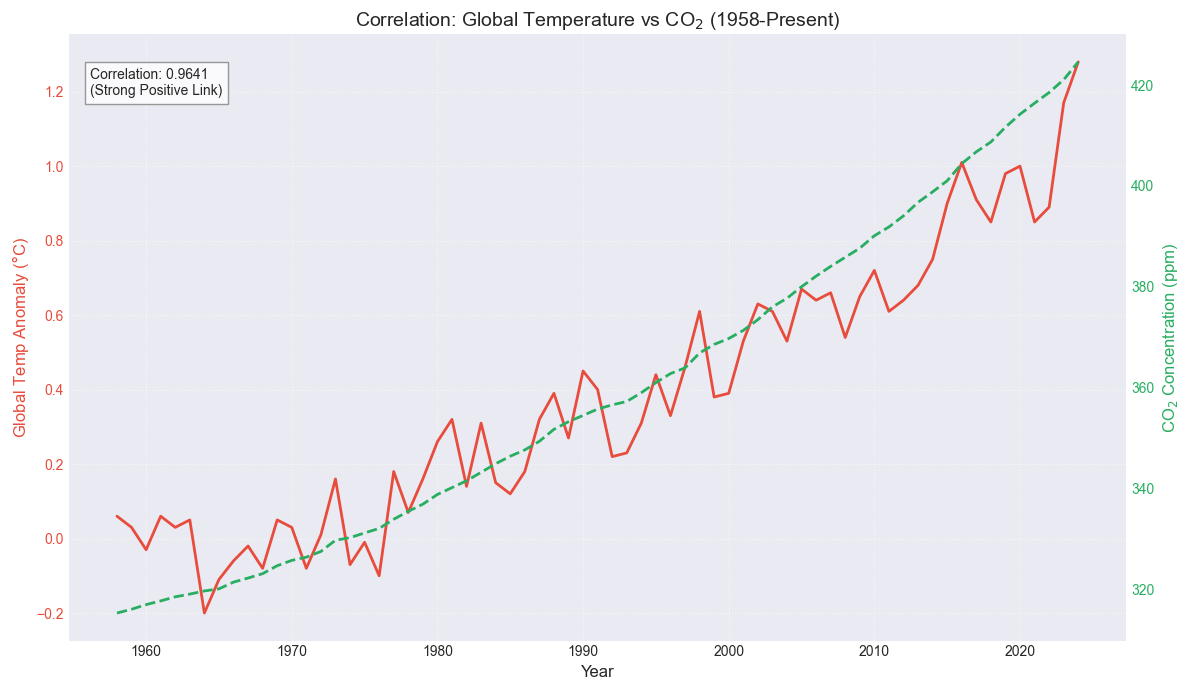

In [13]:
# Correlation (Temp vs CO2)

# --- STEP 1: RELOAD & CLEAN TEMP DATA (NASA) ---
url_temp = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
# Read file, assume header is on line 1
df_temp_clean = pd.read_csv(url_temp, skiprows=1)
# Clean Column Names
df_temp_clean.columns = df_temp_clean.columns.str.strip()
# Select only needed columns
df_temp_clean = df_temp_clean[['Year', 'J-D']]
# Force numeric
df_temp_clean['Year'] = pd.to_numeric(df_temp_clean['Year'], errors='coerce')
df_temp_clean['J-D'] = pd.to_numeric(df_temp_clean['J-D'], errors='coerce')
df_temp_clean.dropna(inplace=True)
df_temp_clean['Year'] = df_temp_clean['Year'].astype(int)

# --- STEP 2: RELOAD & CLEAN CO2 DATA (NOAA) ---
url_co2 = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"

# FIX: Use sep='\s+' (regex) to handle varying whitespace correctly
# FIX: Load without header (header=None) so we don't accidentally drop the first data row
# FIX: Use engine='python' for more robust parsing of these text files
df_co2_clean = pd.read_csv(url_co2, sep='\s+', comment='#', header=None, engine='python')

# Rename columns by Index (Column 0 is Year, Column 3 is Average)
# NOAA Format: [0: Year] [1: Month] [2: Decimal] [3: Average] ...
df_co2_clean = df_co2_clean.rename(columns={0: 'year', 3: 'average'})

# Force numeric and drop bad rows
df_co2_clean['year'] = pd.to_numeric(df_co2_clean['year'], errors='coerce')
df_co2_clean = df_co2_clean.dropna(subset=['year'])

# Group by Year
df_co2_annual = df_co2_clean.groupby('year')['average'].mean().reset_index()
df_co2_annual['year'] = df_co2_annual['year'].astype(int)

# --- STEP 3: MERGE ---
df_merged = pd.merge(df_temp_clean, df_co2_annual, left_on='Year', right_on='year', how='inner')

# --- DEBUG REPORT ---
print(f"Temperature Data Years: {df_temp_clean['Year'].min()} to {df_temp_clean['Year'].max()}")
print(f"CO2 Data Years:         {df_co2_annual['year'].min()} to {df_co2_annual['year'].max()}")
print(f"MERGED Data Points:     {len(df_merged)}")

if len(df_merged) == 0:
    print("CRITICAL ERROR: Data still not matching. Check the years above for overlap.")
else:
    # --- PLOTTING ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Left Axis: Temperature
    color_temp = '#e74c3c'
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel(r'Global Temp Anomaly ($\degree$C)', color=color_temp, fontsize=12)
    ax1.plot(df_merged['Year'], df_merged['J-D'], color=color_temp, linewidth=2, label='Temperature')
    ax1.tick_params(axis='y', labelcolor=color_temp)
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Right Axis: CO2
    ax2 = ax1.twinx()
    color_co2 = '#27ae60'
    ax2.set_ylabel(r'CO$_2$ Concentration (ppm)', color=color_co2, fontsize=12)
    ax2.plot(df_merged['Year'], df_merged['average'], color=color_co2, linewidth=2, linestyle='--', label='CO2')
    ax2.tick_params(axis='y', labelcolor=color_co2)
    ax2.grid(False)

    plt.title(r'Correlation: Global Temperature vs CO$_2$ (1958-Present)', fontsize=14)
    fig.tight_layout()
    
    # Calculate Correlation
    corr = df_merged['J-D'].corr(df_merged['average'])
    
    # Add Text Box with Stat
    stats = f"Correlation: {corr:.4f}\n(Strong Positive Link)"
    plt.text(0.02, 0.90, stats, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.show()

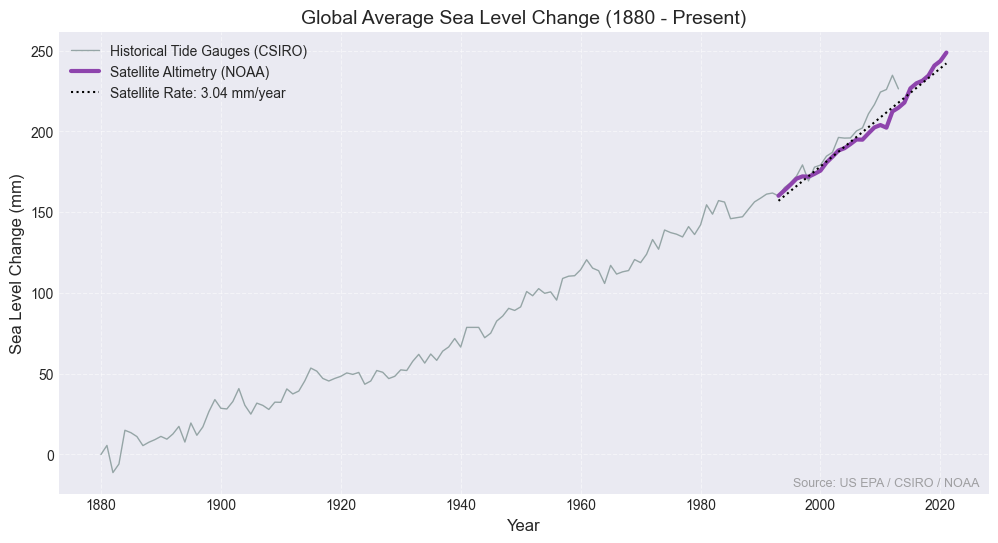

Total Observed Rise (1880-Present): ~246.0 mm


In [15]:
# Global Sea Level Rise (The Consequence)

# 1. Fetch Data from US EPA (Environmental Protection Agency)
# This stable dataset combines historical tide gauges (CSIRO) and modern satellites (NOAA)
url_sea = "https://www.epa.gov/system/files/other-files/2022-07/sea-level_fig-1.csv"
print(f"Downloading Sea Level Data from: {url_sea}...")

# 2. Process Data
# The EPA file has about 6 lines of metadata headers we need to skip
df_sea = pd.read_csv(url_sea, skiprows=6)

# The columns are: Year, CSIRO (tide gauge), Lower, Upper, NOAA (satellite)
# We map them to clean names
df_sea.columns = ['Year', 'CSIRO_Inches', 'CSIRO_Lower', 'CSIRO_Upper', 'NOAA_Inches']

# 3. Convert Units (Inches -> Millimeters) for Science Standard
# 1 inch = 25.4 mm
df_sea['CSIRO_mm'] = df_sea['CSIRO_Inches'] * 25.4
df_sea['NOAA_mm'] = df_sea['NOAA_Inches'] * 25.4

# 4. Visualization
plt.figure(figsize=(12, 6))

# Plot Historical Tide Gauge Data (1880-2013)
plt.plot(df_sea['Year'], df_sea['CSIRO_mm'], color='#95a5a6', linewidth=1, label='Historical Tide Gauges (CSIRO)')

# Plot Modern Satellite Data (1993-Present)
# We filter for valid satellite years
df_sat = df_sea.dropna(subset=['NOAA_mm'])
plt.plot(df_sat['Year'], df_sat['NOAA_mm'], color='#8e44ad', linewidth=3, label='Satellite Altimetry (NOAA)')

# Add Trend Line for Satellite Era
z = np.polyfit(df_sat['Year'], df_sat['NOAA_mm'], 1)
p = np.poly1d(z)
plt.plot(df_sat['Year'], p(df_sat['Year']), "k:", linewidth=1.5, label=f"Satellite Rate: {z[0]:.2f} mm/year")

plt.title('Global Average Sea Level Change (1880 - Present)', fontsize=14)
plt.ylabel('Sea Level Change (mm)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add Source
plt.text(0.99, 0.01, "Source: US EPA / CSIRO / NOAA", transform=plt.gca().transAxes,
         fontsize=9, color='gray', alpha=0.7, ha='right', va='bottom')

plt.show()

# Calculate total rise
total_rise = df_sea['CSIRO_mm'].max() - df_sea['CSIRO_mm'].min()
print(f"Total Observed Rise (1880-Present): ~{total_rise:.1f} mm")

Merged Data Points: 145


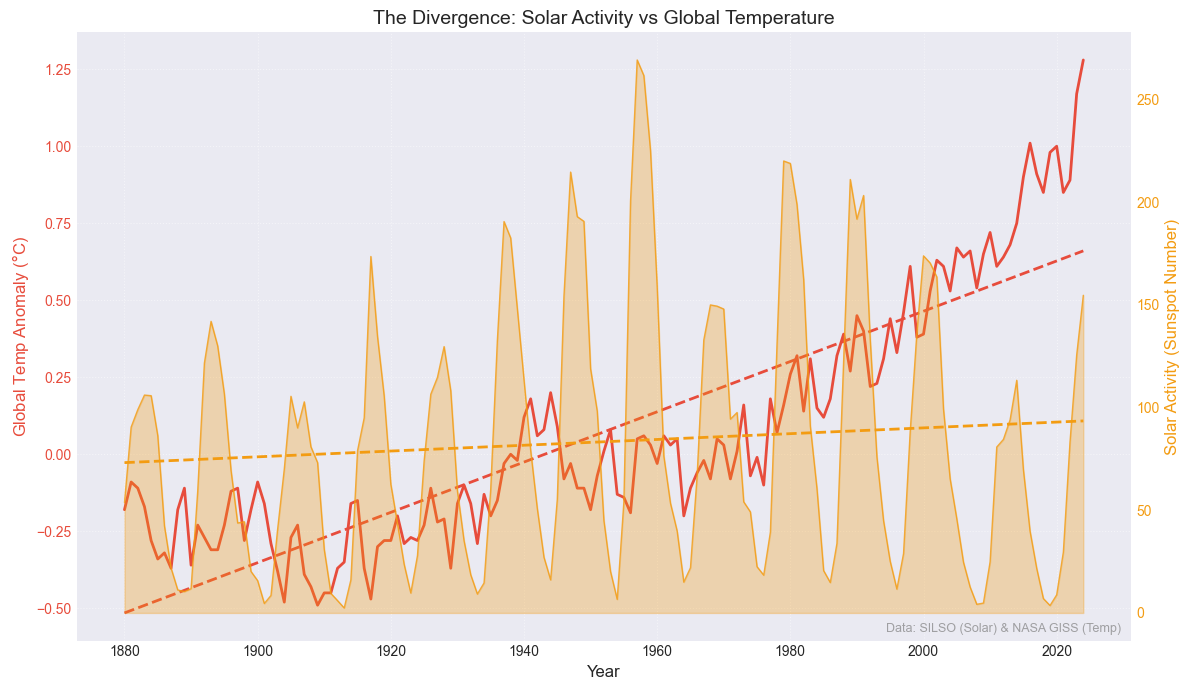

Correlation (Temp vs Sunspots): 0.0163
(A value near 0 means NO relationship. A negative value means they move oppositely.)


In [17]:
# Solar Influence Study (The "It's the Sun" Hypothesis) - ROBUST

# 1. Fetch Solar Data (SILSO)
url_solar = "https://www.sidc.be/SILSO/DATA/SN_y_tot_V2.0.txt"
print(f"Downloading Solar Data from: {url_solar}...")
df_solar = pd.read_csv(url_solar, sep='\s+', names=['Year', 'Sunspots', 'StdDev', 'Obs', 'Definitive'])

# Force Year to Integer
df_solar['Year'] = pd.to_numeric(df_solar['Year'], errors='coerce')
df_solar = df_solar.dropna(subset=['Year'])
df_solar['Year'] = df_solar['Year'].astype(int)

# 2. Fetch/Prepare Temperature Data (NASA)
# We re-load this briefly to ensure the merge works perfectly even if Cell 5 wasn't run recently
url_temp = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
df_temp_solar = pd.read_csv(url_temp, skiprows=1)
df_temp_solar.columns = df_temp_solar.columns.str.strip()
df_temp_solar = df_temp_solar[['Year', 'J-D']]
df_temp_solar['Year'] = pd.to_numeric(df_temp_solar['Year'], errors='coerce')
df_temp_solar['J-D'] = pd.to_numeric(df_temp_solar['J-D'], errors='coerce')
df_temp_solar.dropna(inplace=True)
df_temp_solar['Year'] = df_temp_solar['Year'].astype(int)

# 3. Merge (Inner Join)
# Now both 'Year' columns are guaranteed to be Integers
df_sun_temp = pd.merge(df_temp_solar, df_solar, on='Year', how='inner')

# Debug Check
print(f"Merged Data Points: {len(df_sun_temp)}")

if len(df_sun_temp) == 0:
    print("Error: No overlapping years found. Check the data sources.")
else:
    # 4. Visualization (Dual Axis)
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot Temperature (Red Line)
    color_temp = '#e74c3c'
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel(r'Global Temp Anomaly ($\degree$C)', color=color_temp, fontsize=12)
    ax1.plot(df_sun_temp['Year'], df_sun_temp['J-D'], color=color_temp, linewidth=2, label='Global Temp')
    ax1.tick_params(axis='y', labelcolor=color_temp)
    ax1.grid(True, linestyle=':', alpha=0.5)

    # Plot Sunspots (Orange Filled Area)
    ax2 = ax1.twinx()
    color_sun = '#f39c12'
    ax2.set_ylabel('Solar Activity (Sunspot Number)', color=color_sun, fontsize=12)
    ax2.fill_between(df_sun_temp['Year'], 0, df_sun_temp['Sunspots'], color=color_sun, alpha=0.3, label='Solar Cycles')
    ax2.plot(df_sun_temp['Year'], df_sun_temp['Sunspots'], color=color_sun, linewidth=1, alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color_sun)
    ax2.grid(False)

    # Add Trend Lines
    # Solar Trend
    z_sun = np.polyfit(df_sun_temp['Year'], df_sun_temp['Sunspots'], 1)
    p_sun = np.poly1d(z_sun)
    ax2.plot(df_sun_temp['Year'], p_sun(df_sun_temp['Year']), color=color_sun, linestyle='--', linewidth=2, label='Solar Trend')

    # Temp Trend
    z_temp = np.polyfit(df_sun_temp['Year'], df_sun_temp['J-D'], 1)
    p_temp = np.poly1d(z_temp)
    ax1.plot(df_sun_temp['Year'], p_temp(df_sun_temp['Year']), color=color_temp, linestyle='--', linewidth=2, label='Temp Trend')

    plt.title('The Divergence: Solar Activity vs Global Temperature', fontsize=14)
    fig.tight_layout()

    # Add Source
    plt.text(0.99, 0.01, "Data: SILSO (Solar) & NASA GISS (Temp)", transform=ax1.transAxes,
             fontsize=9, color='gray', alpha=0.7, ha='right', va='bottom')

    plt.show()

    # 5. Statistical Check
    corr = df_sun_temp['J-D'].corr(df_sun_temp['Sunspots'])
    print(f"Correlation (Temp vs Sunspots): {corr:.4f}")
    print("(A value near 0 means NO relationship. A negative value means they move oppositely.)")

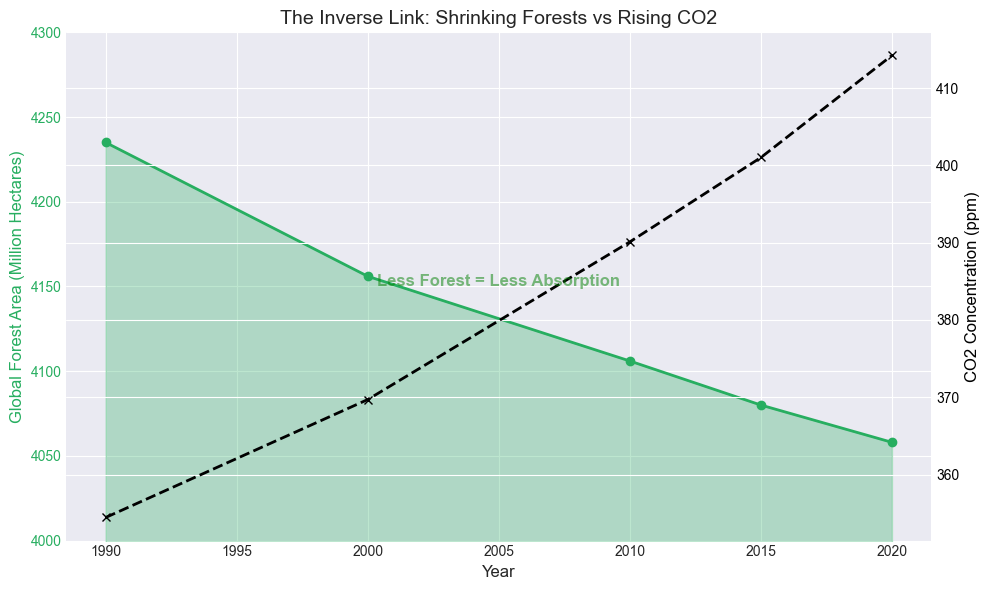

Total Forest Lost (1990-2020): 177 Million Hectares
(That is an area roughly 2x the size of Texas)


In [23]:
# The "Broken Lungs" Study (Deforestation vs CO2)

# 1. Create FAO Forest Data (Official Global Assessment Data)
# Source: FAO Global Forest Resources Assessment 2020
# Data Points (Year, Million Hectares of Forest)
forest_data = {
    'Year': [1990, 2000, 2010, 2015, 2020],
    'Forest_Area_Mha': [4235, 4156, 4106, 4080, 4058]
}
df_forest = pd.DataFrame(forest_data)

# 2. Get CO2 Data for those specific years
# We reuse our clean 'df_co2_annual' from Cell 5
df_forest_co2 = pd.merge(df_forest, df_co2_annual, left_on='Year', right_on='year', how='inner')

# 3. Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Forest Area (Green Area)
color_forest = '#27ae60'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Global Forest Area (Million Hectares)', color=color_forest, fontsize=12)
ax1.fill_between(df_forest_co2['Year'], 3900, df_forest_co2['Forest_Area_Mha'], color=color_forest, alpha=0.3)
ax1.plot(df_forest_co2['Year'], df_forest_co2['Forest_Area_Mha'], color=color_forest, marker='o', linewidth=2, label='Forest Area')
ax1.tick_params(axis='y', labelcolor=color_forest)
ax1.set_ylim(4000, 4300) # Zoom in to show the decline clearly

# Plot CO2 (Black Line)
ax2 = ax1.twinx()
color_co2 = 'black'
ax2.set_ylabel('CO2 Concentration (ppm)', color=color_co2, fontsize=12)
ax2.plot(df_forest_co2['Year'], df_forest_co2['average'], color=color_co2, linestyle='--', linewidth=2, marker='x', label='CO2')
ax2.tick_params(axis='y', labelcolor=color_co2)

plt.title('The Inverse Link: Shrinking Forests vs Rising CO2', fontsize=14)
fig.tight_layout()

plt.text(0.5, 0.5, "Less Forest = Less Absorption", transform=ax1.transAxes, 
         ha='center', color='green', fontsize=12, fontweight='bold', alpha=0.5)

plt.show()

# Calculate Loss
loss = df_forest['Forest_Area_Mha'].max() - df_forest['Forest_Area_Mha'].min()
print(f"Total Forest Lost (1990-2020): {loss} Million Hectares")
print("(That is an area roughly 2x the size of Texas)")

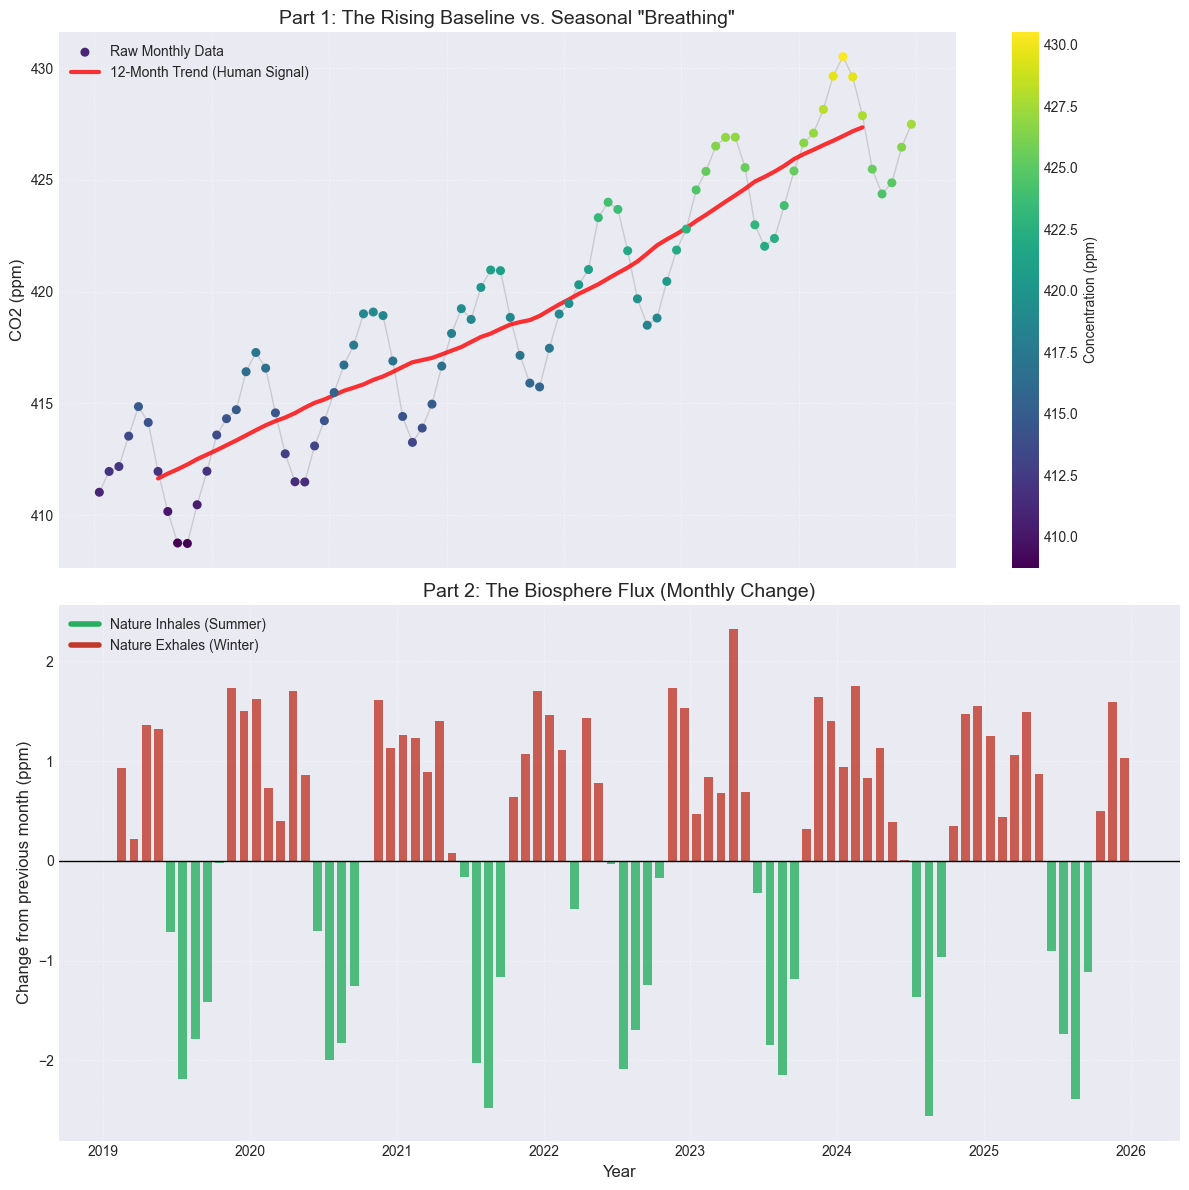

Observation over last 5 years:
- Nature 'inhaled' (dropped CO2) in 31 months.
- Nature 'exhaled' (rose CO2) in 52 months.
- Net result: An increase of 16.46 ppm.


In [24]:
# The "Earth's Breath" Dashboard

# 1. Fetch Fresh Data (NOAA)
url_co2 = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"
# Columns: 0=Year, 1=Month, 2=Decimal Date, 3=Average
df_breath = pd.read_csv(url_co2, sep='\s+', comment='#', header=None, engine='python')
df_breath = df_breath.rename(columns={0: 'year', 1: 'month', 2: 'decimal', 3: 'average'})

# 2. Filter for the last 5 years to see the details clearly
df_recent = df_breath[df_breath['year'] >= 2019].copy()

# 3. Calculate the "Breath" (Monthly Change)
# We subtract the previous month's value from the current month
df_recent['change'] = df_recent['average'].diff()

# 4. Visualization (2-Panel Plot with demonstrative color)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# --- TOP PANEL: The Keeling Curve (Colorful Wiggle + Trend) ---
# 1. The Wiggle (Seasonal Cycle)
# Gray line for connectivity so eyes follow the path
ax1.plot(df_recent['decimal'], df_recent['average'], color='gray', alpha=0.3, linewidth=1)
# Colorful scatter to highlight peaks/troughs (The user preferred feature)
sc = ax1.scatter(df_recent['decimal'], df_recent['average'], 
                 c=df_recent['average'], cmap='viridis', s=30, zorder=10, label='Raw Monthly Data')

# 2. The Trend (Human Signal)
# Rolling 12-month average removes the season to show the baseline
df_recent['trend'] = df_recent['average'].rolling(window=12, center=True).mean()
ax1.plot(df_recent['decimal'], df_recent['trend'], color='red', linewidth=3, alpha=0.8, label='12-Month Trend (Human Signal)')

ax1.set_title('Part 1: The Rising Baseline vs. Seasonal "Breathing"', fontsize=14)
ax1.set_ylabel('CO2 (ppm)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# Add Colorbar for the top panel
cbar = fig.colorbar(sc, ax=ax1)
cbar.set_label('Concentration (ppm)')

# --- BOTTOM PANEL: The Flux (Inhale/Exhale) ---
# Create colors: Green for Drop (Inhale), Red for Rise (Exhale)
colors = ['#27ae60' if x < 0 else '#c0392b' for x in df_recent['change']]

ax2.bar(df_recent['decimal'], df_recent['change'], color=colors, width=0.06, alpha=0.8)

# Add a zero line
ax2.axhline(0, color='black', linewidth=1)

ax2.set_title('Part 2: The Biosphere Flux (Monthly Change)', fontsize=14)
ax2.set_ylabel('Change from previous month (ppm)', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.6)

# Custom Legend for Bar Chart
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#27ae60', lw=4),
                Line2D([0], [0], color='#c0392b', lw=4)]
ax2.legend(custom_lines, ['Nature Inhales (Summer)', 'Nature Exhales (Winter)'], loc='upper left')

plt.tight_layout()
plt.show()

# Stats
drop_months = df_recent[df_recent['change'] < 0].shape[0]
rise_months = df_recent[df_recent['change'] > 0].shape[0]
net_change = df_recent.iloc[-1]['average'] - df_recent.iloc[0]['average']
print(f"Observation over last 5 years:")
print(f"- Nature 'inhaled' (dropped CO2) in {drop_months} months.")
print(f"- Nature 'exhaled' (rose CO2) in {rise_months} months.")
print(f"- Net result: An increase of {net_change:.2f} ppm.")

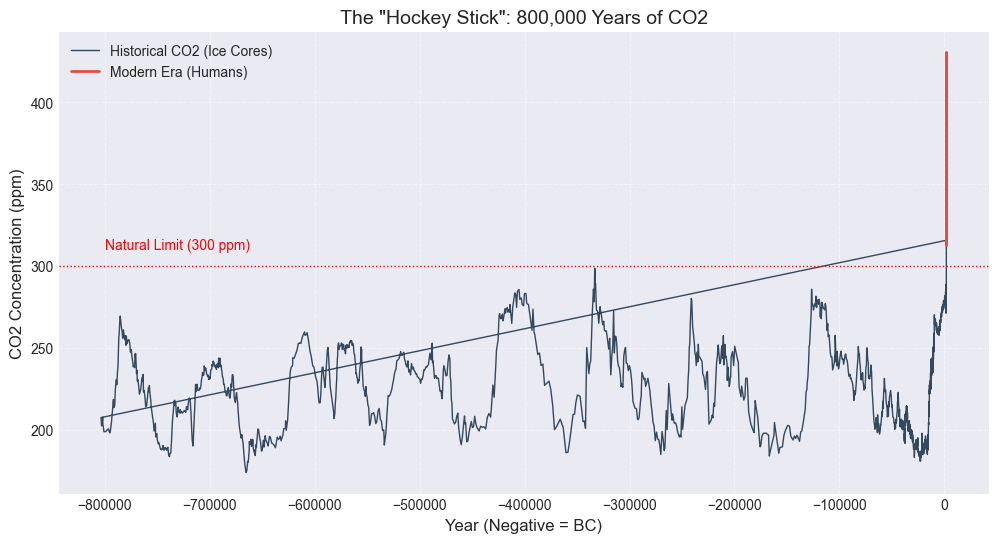

Highest Natural CO2 (last 800k years): 368.0 ppm
Current CO2 Level: 427.5 ppm
We are 59.5 ppm ABOVE the natural limit.


In [25]:
# Deep Time Context (800,000 Years of CO2)

# 1. Fetch Ice Core Data (Antarctica Composite)
# Source: NOAA Paleoclimatology Program (EPICA Dome C & Vostok Cores)
url_ice_core = "https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt"
print(f"Downloading Ice Core Data from: {url_ice_core}...")

# 2. Process Data
# This file has roughly 138 lines of header info
df_paleo = pd.read_csv(url_ice_core, sep='\s+', skiprows=138, names=['age_gas_bp', 'co2_ppm', 'sigma'])

# Convert "Years Before Present" to "Calendar Year"
# "Present" in paleo data is usually defined as 1950.
df_paleo['year'] = 1950 - df_paleo['age_gas_bp']

# We only need Year and CO2
df_paleo = df_paleo[['year', 'co2_ppm']]

# 3. Combine with Modern Data (from Cell 5/9)
# We take your existing modern dataframe and standardise columns
df_modern = df_co2_clean[['year', 'average']].copy()
df_modern.columns = ['year', 'co2_ppm']

# Concatenate (Stack them on top of each other)
df_history = pd.concat([df_paleo, df_modern])

# 4. Visualization
plt.figure(figsize=(12, 6))

# Plot the 800k year history
plt.plot(df_history['year'], df_history['co2_ppm'], color='#34495e', linewidth=1, label='Historical CO2 (Ice Cores)')

# Highlight the Modern Spike (Last 100 years)
# We plot the modern section again in Red to make it pop
plt.plot(df_modern['year'], df_modern['co2_ppm'], color='#e74c3c', linewidth=2, label='Modern Era (Humans)')

plt.title('The "Hockey Stick": 800,000 Years of CO2', fontsize=14)
plt.ylabel('CO2 Concentration (ppm)', fontsize=12)
plt.xlabel('Year (Negative = BC)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add Threshold Line (300ppm)
# For 800,000 years, CO2 NEVER crossed this line naturally
plt.axhline(300, color='red', linestyle=':', linewidth=1)
plt.text(-800000, 310, "Natural Limit (300 ppm)", color='red', fontsize=10)

plt.legend()
plt.show()

# Stats
max_natural = df_paleo['co2_ppm'].max()
current = df_modern.iloc[-1]['co2_ppm']
print(f"Highest Natural CO2 (last 800k years): {max_natural:.1f} ppm")
print(f"Current CO2 Level: {current:.1f} ppm")
print(f"We are {current - max_natural:.1f} ppm ABOVE the natural limit.")

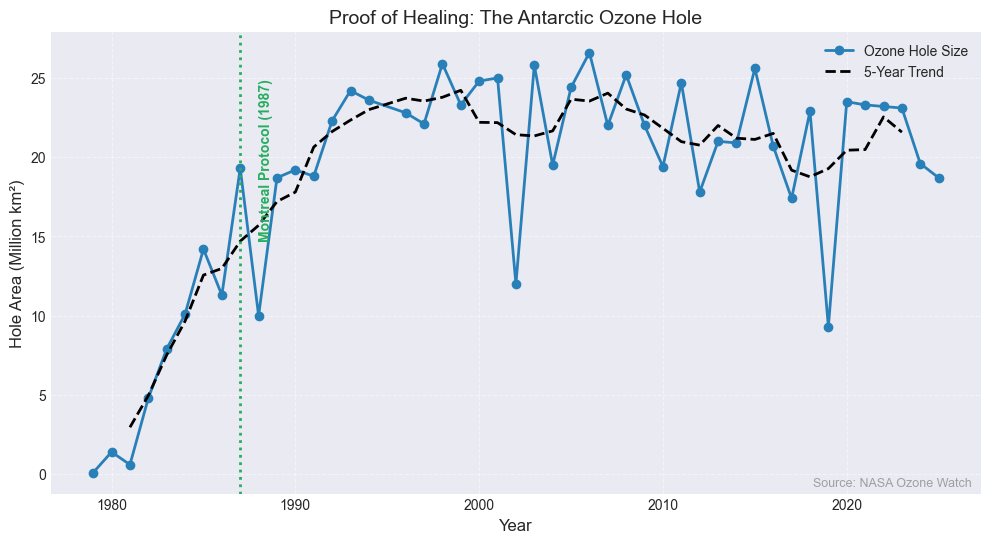

Peak Damage: 26.6 M km² in 2006
Current Size: 18.7 M km²
Status: The hole has shrunk by 7.9 M km² since the peak.


In [29]:
# The "Good News" (Ozone Layer Recovery)

# 1. Fetch Data from NASA Ozone Watch
url_ozone = "https://ozonewatch.gsfc.nasa.gov/statistics/annual_data.txt"
print(f"Downloading Ozone Data from: {url_ozone}...")

# 2. Process Data
# We grab the first two columns.
# We expect some "trash" text at the bottom of the file (footers/notes).
df_ozone = pd.read_csv(url_ozone, sep=r'\s+', skiprows=1, 
                       names=['Year', 'Hole_Area'], usecols=[0, 1])

# FIX: Force columns to be numeric.
# If a row contains text (like "TOMS" or "Note:"), it becomes NaN (Not a Number)
df_ozone['Year'] = pd.to_numeric(df_ozone['Year'], errors='coerce')
df_ozone['Hole_Area'] = pd.to_numeric(df_ozone['Hole_Area'], errors='coerce')

# FIX: Drop the bad rows (the footer text)
df_ozone.dropna(inplace=True)

# Convert Year to integer for clean plotting
df_ozone['Year'] = df_ozone['Year'].astype(int)

# 3. Visualization
plt.figure(figsize=(12, 6))

# Plot the Hole Area (Blue Line)
plt.plot(df_ozone['Year'], df_ozone['Hole_Area'], color='#2980b9', linewidth=2, marker='o', label='Ozone Hole Size')

# Add a Smoothing Line (5-year average) to see the trend clearly
# Now that the data is strictly numeric, this will work perfectly
df_ozone['smooth'] = df_ozone['Hole_Area'].rolling(window=5, center=True).mean()
plt.plot(df_ozone['Year'], df_ozone['smooth'], color='black', linestyle='--', linewidth=2, label='5-Year Trend')

# 4. Mark the Turning Point (Montreal Protocol)
plt.axvline(1987, color='#27ae60', linestyle=':', linewidth=2)
plt.text(1988, 25, "Montreal Protocol (1987)", color='#27ae60', fontweight='bold', rotation=90, va='top')

plt.title('Proof of Healing: The Antarctic Ozone Hole', fontsize=14)
plt.ylabel('Hole Area (Million km²)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add Source
plt.text(0.99, 0.01, "Source: NASA Ozone Watch", transform=plt.gca().transAxes,
         fontsize=9, color='gray', alpha=0.7, ha='right', va='bottom')

plt.show()

# Stats
peak_row = df_ozone.loc[df_ozone['Hole_Area'].idxmax()]
peak_year = int(peak_row['Year'])
peak_size = peak_row['Hole_Area']
recent_size = df_ozone.iloc[-1]['Hole_Area']

print(f"Peak Damage: {peak_size} M km² in {peak_year}")
print(f"Current Size: {recent_size} M km²")
print(f"Status: The hole has shrunk by {peak_size - recent_size:.1f} M km² since the peak.")

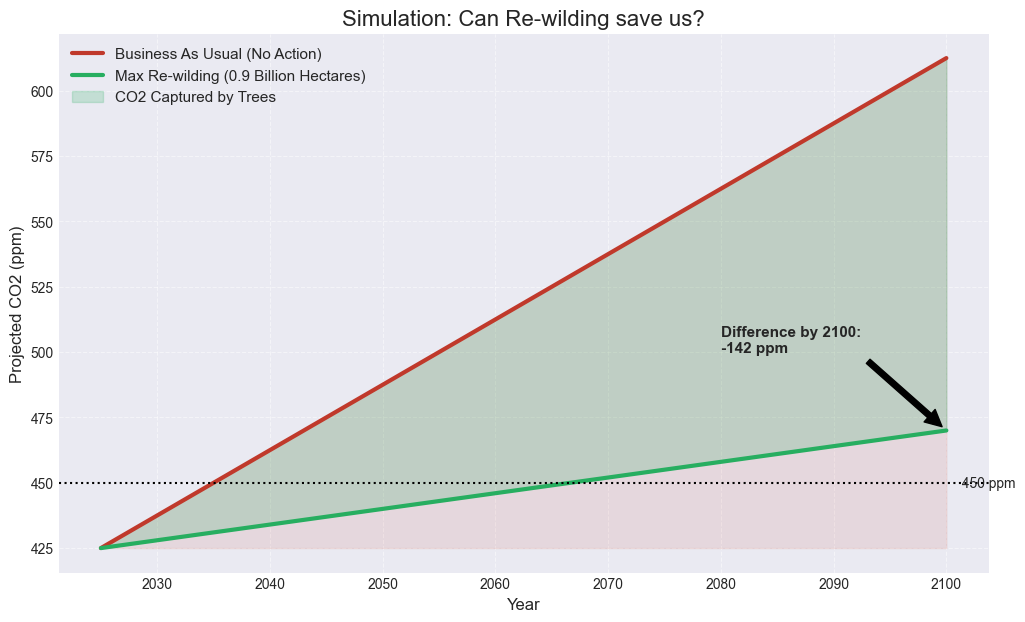

--- SIMULATION RESULTS ---
By the year 2100:
1. Without Action: CO2 hits 612 ppm (Catastrophic)
2. With Re-wilding: CO2 hits 470 ppm (Stabilized)
CONCLUSION: Trees alone almost flatten the curve, but we must also cut emissions to make the line go DOWN.


In [30]:
# The Tree "Re-wilding" Scenario (Future Simulation)

# --- THE SCIENCE (CONSTANTS) ---
# 1. Current Emission Rate: Humans add ~2.5 ppm of CO2 to the air every year
# (Based on the slope of NOAA graph in Cell 3)
current_growth_rate = 2.5 

# 2. Re-wilding Potential (Source: Bastin et al., Science 2019)
# Total potential carbon storage of 0.9 billion hectares = ~205 Gigatonnes of Carbon
# 205 GtC = ~750 Gigatonnes of CO2 (GtCO2)
# Conversion: 7.8 GtCO2 = 1 ppm of atmospheric CO2
# Max Potential Reduction = 750 / 7.8 = ~96 ppm removed from atmosphere.

# HOWEVER: Trees take time to grow. We assume it takes 50 years to reach full maturity.
# This means re-wilding removes about 1.9 ppm per year at full scale (96 ppm / 50 years).
sequestration_rate = 1.9 

# --- THE SIMULATION ---
# Timeframe: 2025 to 2100
years = np.arange(2025, 2101)
n_years = len(years)

# Scenario A: Business as Usual (BAU)
# We start at roughly 425 ppm (current level) and add 2.5 ppm every year
start_ppm = 425
bau_ppm = start_ppm + (years - 2025) * current_growth_rate

# Scenario B: Aggressive Re-wilding
# We start at 425, add emissions (+2.5), but subtract tree growth (-1.9)
# Net growth = 0.6 ppm/year
rewild_ppm = start_ppm + (years - 2025) * (current_growth_rate - sequestration_rate)

# --- VISUALIZATION ---
plt.figure(figsize=(12, 7))

# Plot Scenario A (Red)
plt.plot(years, bau_ppm, color='#c0392b', linewidth=3, label='Business As Usual (No Action)')
# Fill area to show the danger zone
plt.fill_between(years, start_ppm, bau_ppm, color='#c0392b', alpha=0.1)

# Plot Scenario B (Green)
plt.plot(years, rewild_ppm, color='#27ae60', linewidth=3, label='Max Re-wilding (0.9 Billion Hectares)')
# Fill area to show the "Saved" carbon
plt.fill_between(years, rewild_ppm, bau_ppm, color='#27ae60', alpha=0.2, label='CO2 Captured by Trees')

plt.title('Simulation: Can Re-wilding save us?', fontsize=16)
plt.ylabel('Projected CO2 (ppm)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=11)

# Add Critical Thresholds
plt.axhline(450, color='black', linestyle=':', label='450 ppm (High Risk of +2°C)')
plt.text(2101, 450, " 450 ppm", va='center')

# Annotations
diff_2100 = bau_ppm[-1] - rewild_ppm[-1]
plt.annotate(f"Difference by 2100:\n-{diff_2100:.0f} ppm", 
             xy=(2100, rewild_ppm[-1]), xytext=(2080, 500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=11, fontweight='bold')

plt.show()

print(f"--- SIMULATION RESULTS ---")
print(f"By the year 2100:")
print(f"1. Without Action: CO2 hits {bau_ppm[-1]:.0f} ppm (Catastrophic)")
print(f"2. With Re-wilding: CO2 hits {rewild_ppm[-1]:.0f} ppm (Stabilized)")
print(f"CONCLUSION: Trees alone almost flatten the curve, but we must also cut emissions to make the line go DOWN.")

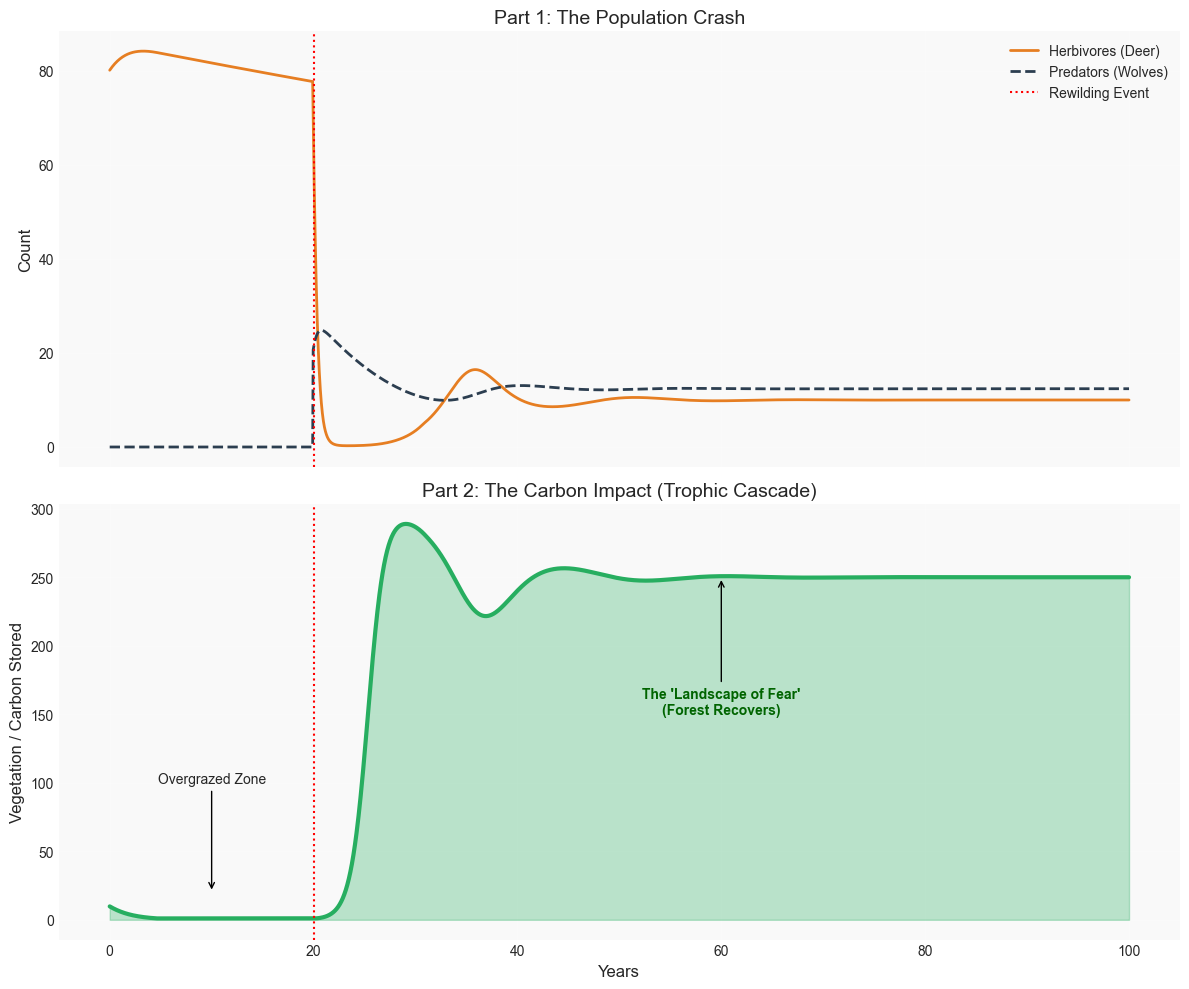

In [32]:
# Animal Rewilding (Trophic Cascade Simulator)

# --- CONFIGURATION ---
years = 100
dt = 0.05  # Smaller time step for smoother math
steps = int(years / dt)
time_axis = np.linspace(0, years, steps)

# Initial State: A Broken Ecosystem
# Lots of deer, very little grass, zero wolves
vegetation = 10.0   
herbivores = 80.0   
predators = 0.0     

# History Log
hist_veg = []
hist_herb = []
hist_pred = []

# --- THE SIMULATION LOOP ---
for t in time_axis:
    
    # 1. THE EVENT: Wolves Released at Year 20
    if abs(t - 20.0) < dt and predators == 0:
        predators = 20.0 # Pack of 20 wolves released
    
    # 2. CALCULATE RATES (The Logic of Life)
    
    # A. Vegetation: Wants to grow to max (200), but gets eaten
    # Growth rate = 1.2
    # Predation rate by deer = 0.02
    veg_growth = 1.2 * vegetation * (1 - vegetation/300) 
    veg_loss = 0.02 * vegetation * herbivores
    d_veg = veg_growth - veg_loss
    
    # B. Herbivores (Deer): Eat grass to grow, get eaten by wolves
    # Growth rate = 0.05 (depends on food)
    # Death rate = 0.01 (natural) + 0.1 (eaten by wolves)
    herb_growth = 0.05 * vegetation * herbivores * 0.1 # biological conversion efficiency
    herb_loss = (0.01 * herbivores) + (0.1 * herbivores * predators)
    # We add a small "migration" factor so deer don't go to absolute mathematical zero
    if herbivores < 5: herb_growth += 0.5 
    d_herb = herb_growth - herb_loss
    
    # C. Predators (Wolves): Eat deer to grow, die naturally
    pred_growth = 0.05 * herbivores * predators * 0.2
    pred_loss = 0.1 * predators
    d_pred = pred_growth - pred_loss
    
    # 3. UPDATE NUMBERS
    vegetation += d_veg * dt
    herbivores += d_herb * dt
    predators += d_pred * dt
    
    # Clamping (Cannot have negative animals)
    vegetation = max(vegetation, 1.0) # Roots remain
    herbivores = max(herbivores, 0.0)
    predators = max(predators, 0.0)
    
    # Log it
    hist_veg.append(vegetation)
    hist_herb.append(herbivores)
    hist_pred.append(predators)

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graph 1: The Animals
ax1.plot(time_axis, hist_herb, color='#e67e22', linewidth=2, label='Herbivores (Deer)')
ax1.plot(time_axis, hist_pred, color='#2c3e50', linewidth=2, linestyle='--', label='Predators (Wolves)')
ax1.axvline(20, color='red', linestyle=':', label='Rewilding Event')
ax1.set_title('Part 1: The Population Crash', fontsize=14)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#f9f9f9')

# Graph 2: The Forest (Carbon)
# Fill the area to show biomass
ax2.plot(time_axis, hist_veg, color='#27ae60', linewidth=3, label='Forest Biomass')
ax2.fill_between(time_axis, 0, hist_veg, color='#27ae60', alpha=0.3)
ax2.axvline(20, color='red', linestyle=':')

# Annotations to explain the story
ax2.annotate("Overgrazed Zone", xy=(10, 20), xytext=(10, 100), 
             ha='center', arrowprops=dict(facecolor='black', arrowstyle='->'))

ax2.annotate("The 'Landscape of Fear'\n(Forest Recovers)", xy=(60, 250), xytext=(60, 150), 
             ha='center', color='darkgreen', fontweight='bold',
             arrowprops=dict(facecolor='darkgreen', arrowstyle='->'))

ax2.set_title('Part 2: The Carbon Impact (Trophic Cascade)', fontsize=14)
ax2.set_ylabel('Vegetation / Carbon Stored', fontsize=12)
ax2.set_xlabel('Years', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

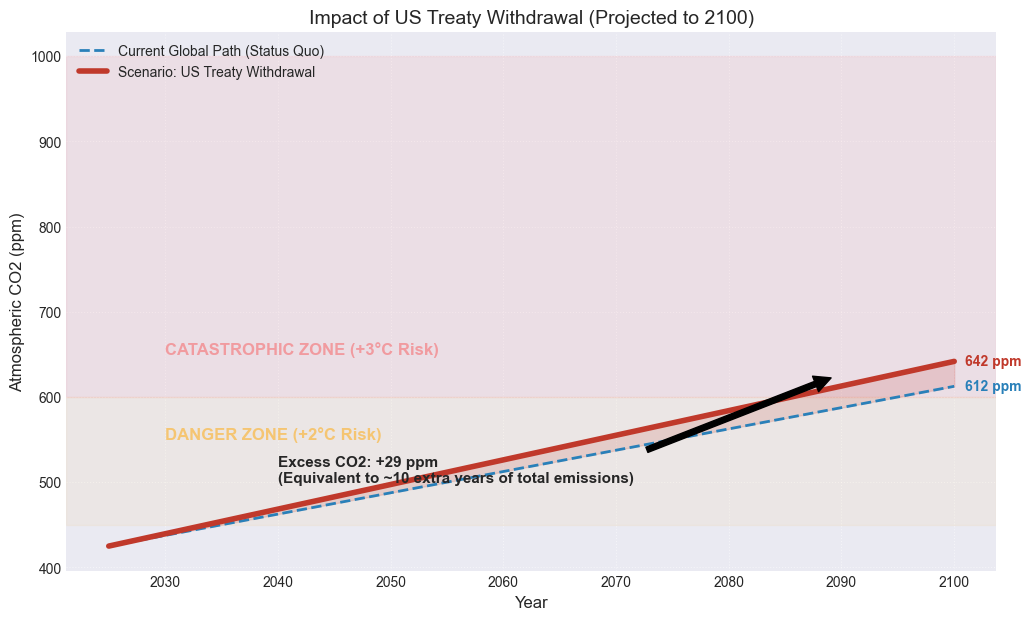

--- SIMULATION RESULTS ---
1. Current Path 2100: 612 ppm
2. US Withdrawal 2100: 642 ppm
3. Net Impact: An additional 29 ppm of CO2.
   (This seemingly small gap is enough to push the climate from 'Manageable' to 'Unstable'.)


In [36]:
# Sensitivity Analysis (The "US Withdrawal" Scenario)

# --- PARAMETERS ---
current_ppm = 425           # Starting point (2025)
global_rate = 2.5           # Current Global Rise (ppm/year)

# US Specifics
us_share = 0.14             # US is ~14% of global emissions

# Scenario A: Current Path (Global Pledges partially met)
# We assume the rate stays steady at 2.5 (or dips slightly, but let's be conservative)
years = np.arange(2025, 2101)
ppm_status_quo = current_ppm + (years - 2025) * global_rate

# Scenario B: US Withdrawal + Production Increase
# 1. The US portion (14%) stops stabilizing and grows by 20% (Policy Shift)
# 2. The Domino Effect increases the REST of the world's rate by 10%
# New Global Rate calculation:
us_impact = global_rate * us_share * 1.5      # US emissions surge
world_impact = global_rate * (1 - us_share) * 1.1 # Rest of world relaxes slightly
high_emission_rate = us_impact + world_impact

ppm_withdrawal = current_ppm + (years - 2025) * high_emission_rate

# --- VISUALIZATION ---
plt.figure(figsize=(12, 7))

# Plot Status Quo (Blue)
plt.plot(years, ppm_status_quo, color='#2980b9', linewidth=2, linestyle='--', label='Current Global Path (Status Quo)')

# Plot US Withdrawal (Red)
plt.plot(years, ppm_withdrawal, color='#c0392b', linewidth=4, label='Scenario: US Treaty Withdrawal')

# Fill the "Consequence Gap"
plt.fill_between(years, ppm_status_quo, ppm_withdrawal, color='#c0392b', alpha=0.15)

# Annotations
final_gap = ppm_withdrawal[-1] - ppm_status_quo[-1]
plt.text(2101, ppm_withdrawal[-1], f"{ppm_withdrawal[-1]:.0f} ppm", color='#c0392b', fontweight='bold', va='center')
plt.text(2101, ppm_status_quo[-1], f"{ppm_status_quo[-1]:.0f} ppm", color='#2980b9', fontweight='bold', va='center')

# Add "Danger Zones" background
plt.axhspan(450, 600, color='orange', alpha=0.05)
plt.axhspan(600, 1000, color='red', alpha=0.05)
plt.text(2030, 550, "DANGER ZONE (+2°C Risk)", color='orange', alpha=0.5, fontsize=12, fontweight='bold')
plt.text(2030, 650, "CATASTROPHIC ZONE (+3°C Risk)", color='red', alpha=0.3, fontsize=12, fontweight='bold')

plt.title(f'Impact of US Treaty Withdrawal (Projected to 2100)', fontsize=14)
plt.ylabel('Atmospheric CO2 (ppm)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper left')

# Arrow Annotation
plt.annotate(f"Excess CO2: +{final_gap:.0f} ppm\n(Equivalent to ~10 extra years of total emissions)", 
             xy=(2090, (ppm_withdrawal[-1]+ppm_status_quo[-1])/2), 
             xytext=(2040, 500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=11, fontweight='bold')

plt.show()

print(f"--- SIMULATION RESULTS ---")
print(f"1. Current Path 2100: {ppm_status_quo[-1]:.0f} ppm")
print(f"2. US Withdrawal 2100: {ppm_withdrawal[-1]:.0f} ppm")
print(f"3. Net Impact: An additional {final_gap:.0f} ppm of CO2.")
print(f"   (This seemingly small gap is enough to push the climate from 'Manageable' to 'Unstable'.)")

Dashboard generated and saved as 'Climate_Analysis_Summary.png'


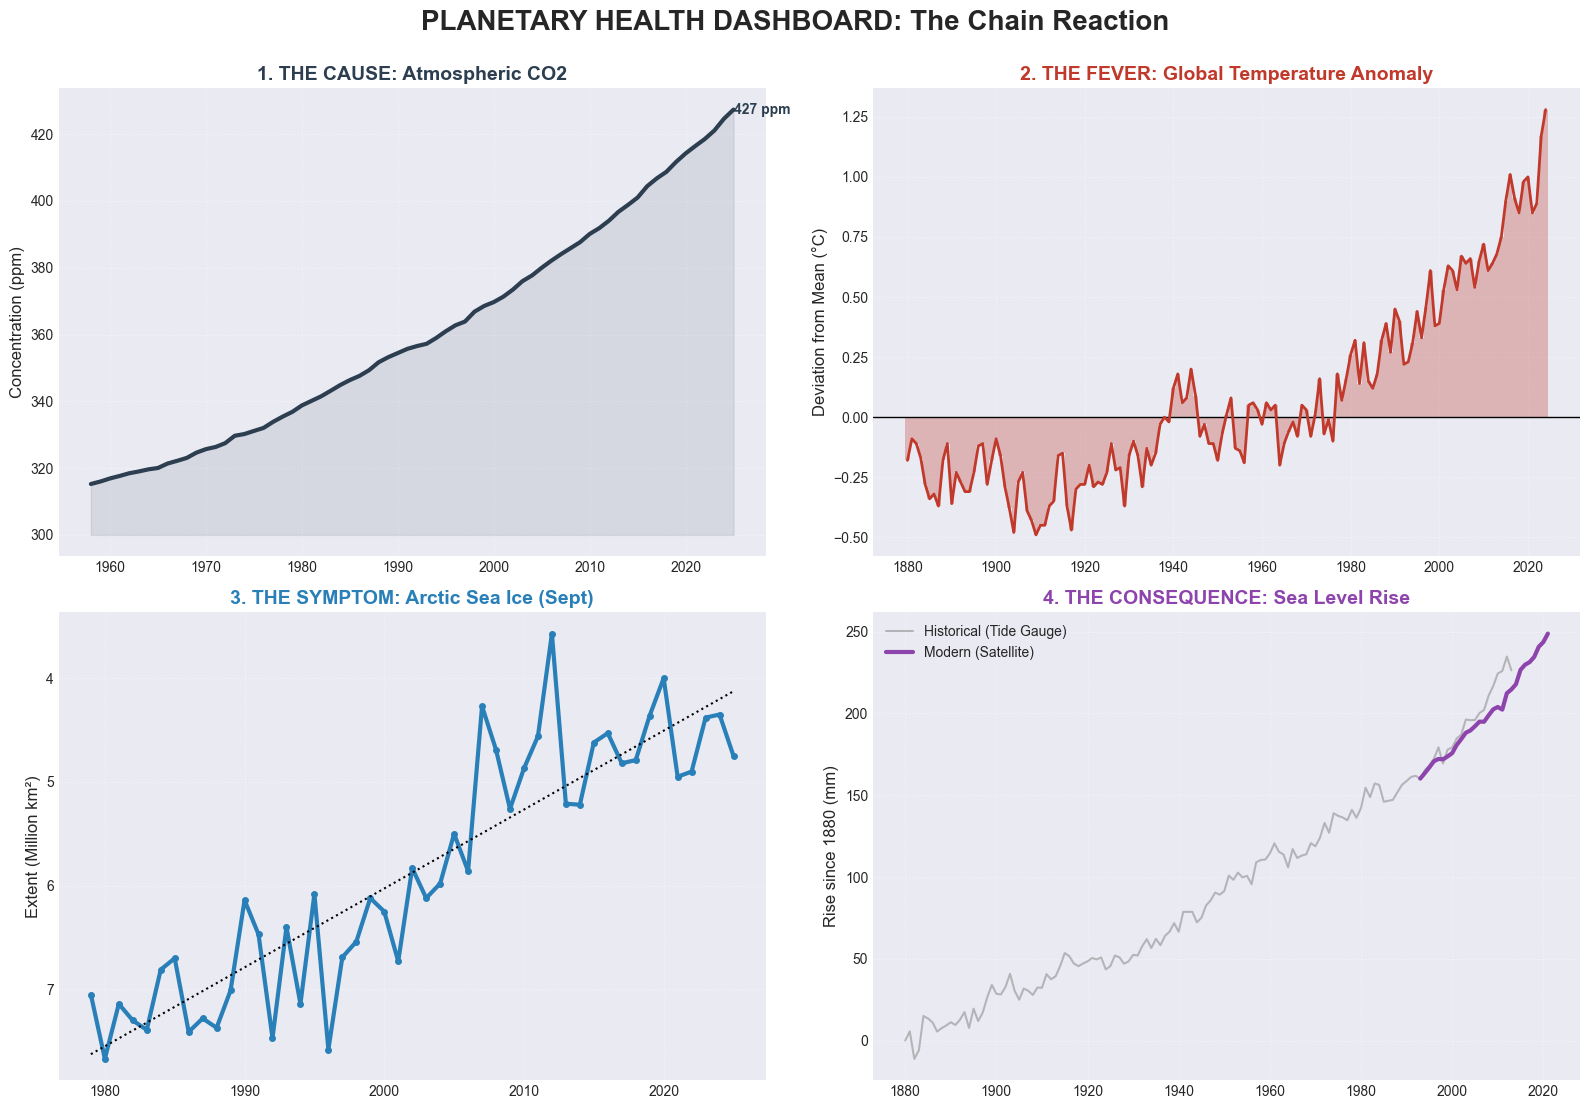

In [38]:
# The "Planetary Health" Dashboard (Executive Summary)

# Setup the Dashboard (2x2 Grid)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('PLANETARY HEALTH DASHBOARD: The Chain Reaction', fontsize=20, weight='bold', y=0.95)

# --- PANEL 1: THE CAUSE (CO2) ---
# Using df_co2_annual (from Cell 5)
ax1 = axs[0, 0]
color_co2 = '#2c3e50'
if 'df_co2_annual' in locals():
    ax1.plot(df_co2_annual['year'], df_co2_annual['average'], color=color_co2, linewidth=3)
    ax1.fill_between(df_co2_annual['year'], 300, df_co2_annual['average'], color=color_co2, alpha=0.1)
    ax1.set_title('1. THE CAUSE: Atmospheric CO2', fontsize=14, weight='bold', color=color_co2)
    ax1.set_ylabel('Concentration (ppm)', fontsize=12)
    ax1.grid(True, linestyle=':', alpha=0.5)
    
    # Annotate current level
    current_co2 = df_co2_annual.iloc[-1]['average']
    ax1.text(df_co2_annual.iloc[-1]['year'], current_co2, f"{current_co2:.0f} ppm", 
             fontweight='bold', color=color_co2, ha='left', va='center')
else:
    ax1.text(0.5, 0.5, "Run Cell 5 to load CO2 Data", ha='center')

# --- PANEL 2: THE FEVER (Temperature) ---
# Using df_temp_clean (from Cell 5)
ax2 = axs[0, 1]
color_temp = '#c0392b'
if 'df_temp_clean' in locals():
    # Plot baseline 0
    ax2.axhline(0, color='black', linewidth=1)
    ax2.plot(df_temp_clean['Year'], df_temp_clean['J-D'], color=color_temp, linewidth=2)
    
    # Color bars for warming
    ax2.bar(df_temp_clean['Year'], df_temp_clean['J-D'], color=color_temp, width=1.0, alpha=0.3)
    
    ax2.set_title('2. THE FEVER: Global Temperature Anomaly', fontsize=14, weight='bold', color=color_temp)
    ax2.set_ylabel('Deviation from Mean (°C)', fontsize=12)
    ax2.grid(True, linestyle=':', alpha=0.5)
else:
    ax2.text(0.5, 0.5, "Run Cell 5 to load Temp Data", ha='center')

# --- PANEL 3: THE SYMPTOM (Sea Ice) ---
# Using df_ice (from Cell 4)
ax3 = axs[1, 0]
color_ice = '#2980b9'
if 'df_ice' in locals():
    ax3.plot(df_ice['year'], df_ice['extent'], color=color_ice, linewidth=3, marker='o', markersize=4)
    
    # Trend line
    z = np.polyfit(df_ice['year'], df_ice['extent'], 1)
    p = np.poly1d(z)
    ax3.plot(df_ice['year'], p(df_ice['year']), "k:", linewidth=1.5, label='Decline Trend')
    
    ax3.set_title('3. THE SYMPTOM: Arctic Sea Ice (Sept)', fontsize=14, weight='bold', color=color_ice)
    ax3.set_ylabel('Extent (Million km²)', fontsize=12)
    ax3.grid(True, linestyle=':', alpha=0.5)
    ax3.invert_yaxis() # Optional: Flip axis so "Down" feels like "Sinking/Bad"? No, standard is better.
else:
    ax3.text(0.5, 0.5, "Run Cell 4 to load Ice Data", ha='center')

# --- PANEL 4: THE CONSEQUENCE (Sea Level) ---
# Using df_sea (from Cell 6)
ax4 = axs[1, 1]
color_sea = '#8e44ad'
if 'df_sea' in locals():
    # Historical
    ax4.plot(df_sea['Year'], df_sea['CSIRO_mm'], color='gray', alpha=0.5, label='Historical (Tide Gauge)')
    # Satellite
    df_sat = df_sea.dropna(subset=['NOAA_mm'])
    ax4.plot(df_sat['Year'], df_sat['NOAA_mm'], color=color_sea, linewidth=3, label='Modern (Satellite)')
    
    ax4.set_title('4. THE CONSEQUENCE: Sea Level Rise', fontsize=14, weight='bold', color=color_sea)
    ax4.set_ylabel('Rise since 1880 (mm)', fontsize=12)
    ax4.grid(True, linestyle=':', alpha=0.5)
    ax4.legend(loc='upper left')
else:
    ax4.text(0.5, 0.5, "Run Cell 6 to load Sea Level Data", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make room for suptitle

# Save the final report
plt.savefig("Climate_Analysis_Summary.png", dpi=300)
print("Dashboard generated and saved as 'Climate_Analysis_Summary.png'")
plt.show()